<a href="https://colab.research.google.com/github/markotesic/ai-workforce-suitability/blob/main/Capability%20Profiles/Capability_profiles_all_items.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install 'pymc>5.9' --quiet
! pip install 'numpyro' --quiet
! pip install 'pytensor' --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 8.1 MB/s eta 0:00:00


In [2]:
import warnings

# Filter warnings for the specific library you want to suppress
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

import arviz as az
import numpy as np
import pandas as pd
import pickle
import os
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, brier_score_loss, average_precision_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
#from tabpfn import TabPFNClassifier, TabPFNRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit as sigmoid
import pytensor.tensor as at
from google.colab import files
plt.rcParams['figure.constrained_layout.use'] = True

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on xgboost v{xgb.__version__}")

Running on PyMC v5.26.1
Running on xgboost v3.1.1


In [3]:
!python --version

Python 3.12.12


In [4]:
all_annotations_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OECD capability profiles/all_annotations_for_selected_items.csv")

In [5]:
all_annotations_data.head()

,dataset name,sample id,Causal Reasoning,Cognitive Flexibility,Emotion Perception and Empathy,Episodic Memory,Functional Perception,Inhibitory Control,Language,Mental Simulation,Metacognition,Object Permanence,Perception and Pattern Recognition,Planning,Procedural Memory,Prospective Memory,Semantic Memory,Spatial Reasoning and Navigation,Theory of Mind,Working Memory
0,AGIEval_freeform,1,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,0.0,3.0,0.0,0.0,3.0
1,AGIEval_freeform,2,2.0,3.0,0.0,0.0,2.0,1.0,2.0,0.0,3.0,0.0,2.0,2.0,2.0,0.0,3.0,0.0,0.0,3.0
2,AGIEval_freeform,4,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,3.0,0.0,2.0,0.0,0.0,3.0
3,AGIEval_freeform,5,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0
4,AGIEval_freeform,6,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,3.0,0.0,3.0,1.0,3.0,0.0,3.0,1.0,0.0,3.0


# Demand correlations

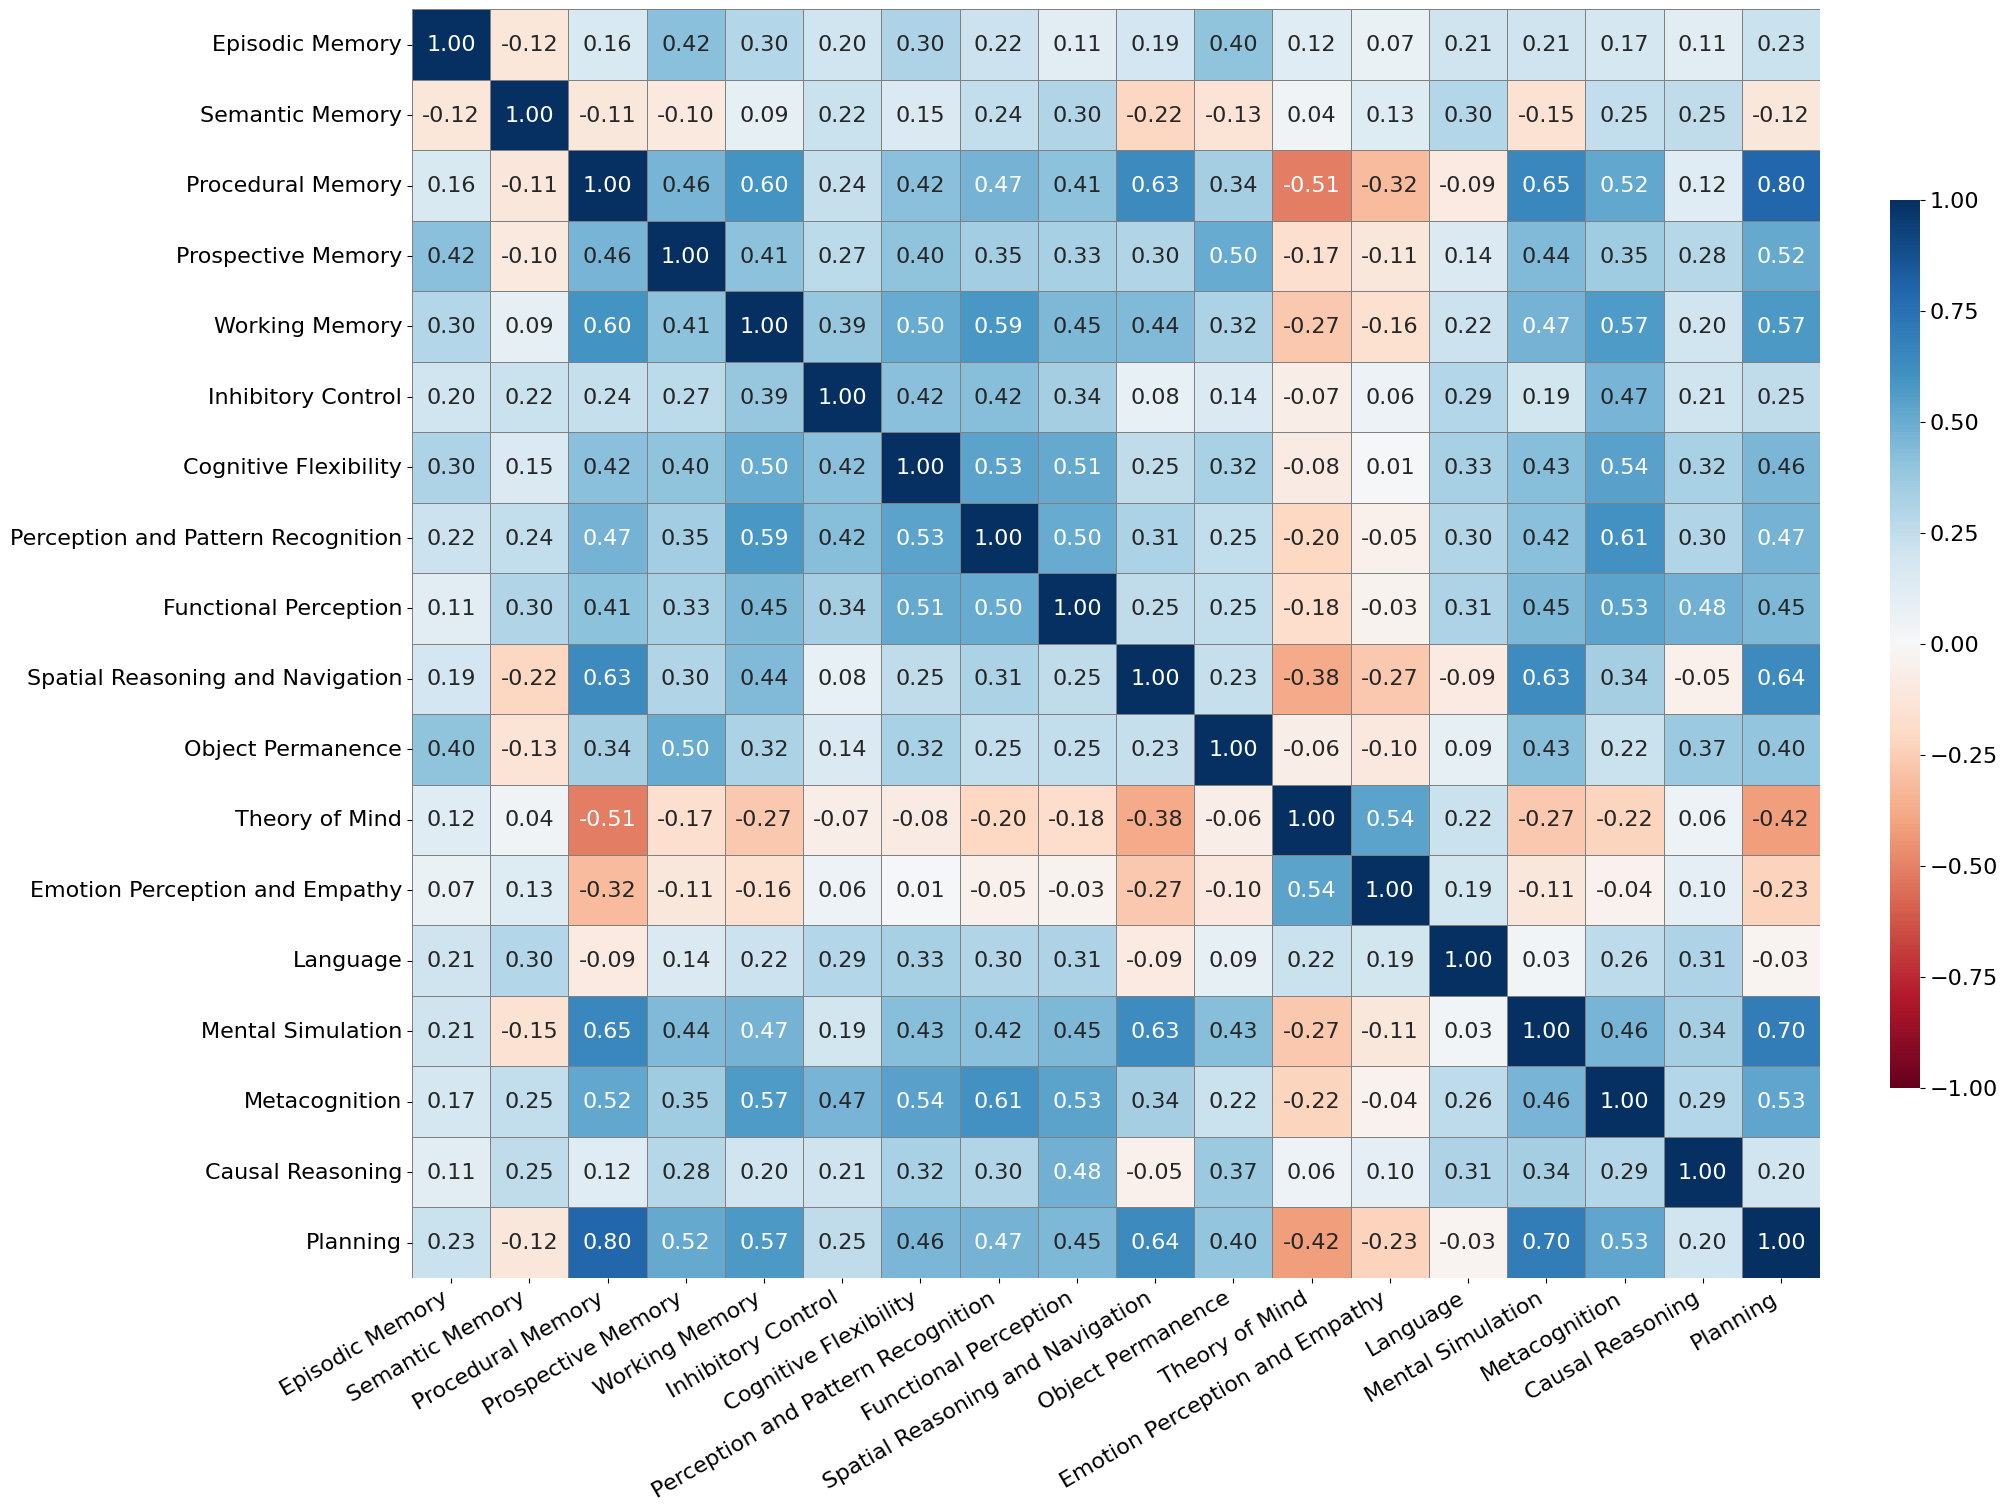

In [6]:
# Drop the specified columns and compute the correlation matrix
correlation_matrix = all_annotations_data.drop(columns=['dataset name', 'sample id']).corr()

# Define the desired order of columns
desired_order = [
    "Episodic Memory", "Semantic Memory", "Procedural Memory", "Prospective Memory", "Working Memory",
    "Inhibitory Control", "Cognitive Flexibility",
    "Perception and Pattern Recognition", "Functional Perception", "Spatial Reasoning and Navigation", "Object Permanence",
    "Theory of Mind", "Emotion Perception and Empathy",
    "Language", "Mental Simulation", "Metacognition",
    "Causal Reasoning", "Planning",
]

# Reindex the correlation matrix according to the desired order
correlation_matrix = correlation_matrix.reindex(index=desired_order, columns=desired_order)

plt.figure(figsize=(20, 15))  # Adjust figure size as needed
ax = sns.heatmap(correlation_matrix, cmap='RdBu', annot=True, fmt=".2f",
                 linewidths=.5, linecolor='gray', vmin=-1, vmax=1,
                 annot_kws={"size": 16}, cbar_kws={"shrink": 0.7, "aspect": 30})

# Make x and y labels bigger and rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

# Make color bar labels bigger and thinner
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
#cbar.ax.set_aspect(10) # Adjust aspect ratio to make it thinner

save = False
if save:
  filename = "/content/drive/MyDrive/Colab Notebooks/OECD capability profiles/demands_correlations.png"
  plt.savefig(filename, dpi=300, bbox_inches='tight')
#plt.title('Correlation Matrix of All Demands')
plt.show()

In [7]:
# Select the upper triangle of the correlation matrix, excluding the diagonal
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Stack the upper triangle to get a Series of correlations
stacked_correlations = upper_triangle.stack()

# Sort the correlations by absolute value in descending order and get the top 20
top_20_correlations = stacked_correlations.loc[stacked_correlations.abs().sort_values(ascending=False).head(20).index]

# Display the top 20 correlations
print("Top 20 Highest Absolute Correlations (showing original values):")
display(top_20_correlations)

Top 20 Highest Absolute Correlations (showing original values):


Procedural Memory                   Planning                              0.796789
Mental Simulation                   Planning                              0.700613
Procedural Memory                   Mental Simulation                     0.653544
Spatial Reasoning and Navigation    Planning                              0.637928
Procedural Memory                   Spatial Reasoning and Navigation      0.633958
Spatial Reasoning and Navigation    Mental Simulation                     0.626415
Perception and Pattern Recognition  Metacognition                         0.608700
Procedural Memory                   Working Memory                        0.596070
Working Memory                      Perception and Pattern Recognition    0.585253
                                    Planning                              0.572537
                                    Metacognition                         0.569746
Cognitive Flexibility               Metacognition                         0.540187
Theory of Mind                      Emotion Perception and Empathy        0.535114
Functional Perception               Metacognition                         0.534813
Cognitive Flexibility               Perception and Pattern Recognition    0.531408
Metacognition                       Planning                              0.529198
Procedural Memory                   Metacognition                         0.516222
Prospective Memory                  Planning                              0.515073
Cognitive Flexibility               Functional Perception                 0.509404
Procedural Memory                   Theory of Mind                       -0.509267
dtype: float64

In [8]:
# Compute the mean absolute correlation for each feature (excluding self-correlation)
mean_abs_corr = correlation_matrix.apply(lambda x: x.abs().sum() - 1, axis=1) / (len(correlation_matrix) - 1)

# Sort from most to least correlated overall
most_correlated = mean_abs_corr.sort_values(ascending=False)

# Display nicely
print("Average absolute correlation of each feature with all others:")
display(most_correlated.to_frame("mean_abs_corr"))

Average absolute correlation of each feature with all others:


,mean_abs_corr
Planning,0.411662
Procedural Memory,0.402500
Working Memory,0.383995
Mental Simulation,0.375367
Metacognition,0.375169
Perception and Pattern Recognition,0.367204
Cognitive Flexibility,0.351951
Functional Perception,0.346134
Prospective Memory,0.327366
Spatial Reasoning and Navigation,0.312193


- Theory of Mind seem to be negatively correlated with a lot of the demands, expect Emotion perception and empathy and Language. Moderately negatively correlated with Procedural memory and Planning (similar hold for Emotion Perception and Empathy).
- Emotion Perception and Empathy least correlated with other features, but exception is Theory of Mind
- Memory ones, not very correlated with each other (good thing I guess) expect Working memory and Procedural memory (which again makes sense).
- Procedural memory quite correlated (.8) with Planning and moderately correlated with Pental simulation and Spatial reasoning and navigation
- Perception and Pattern recognition moderately correlated with Metacognition
- Mental simulation moderately correlated with Procedural memory and Spatial reasoning and navigation and bit more correlated with Planning

# Simulate model performance  

For item $j$ with a $K$-dimensional demand vector $d_{j,\cdot}$ and a single agent with capability vector $c_{\cdot}$:

- Capabilities (log and interval scale): $c_k = \log \theta_k$ (what we infer).
- $\theta_k$: raw capability, on a ratio scale: $\theta_k = e^{c_k}$.
- Per-level multiplier: $\lambda_k$ (each +1 demand step on dim $k$ multiplies raw difficulty by $e^{\lambda_k}$).
- Margin (log-ratio evidence) per dimension:

$$m_{j,k} \;=\; c_k \;-\; \lambda_k\, d_{j,k}
\;=\; \log \frac{\theta_k}{\delta_{j,k}},\quad \delta_{j,k}=e^{\lambda_k d_{j,k}}$$
- $\delta_{j,k}$ is the raw difficulty on ratio scale (because it has an absolute 0 and multiplicative ratios are meaningful)

- Evidence weights (discriminations): $\kappa_k>0$.
- Total evidence/evidence pooling (log-odds):
$$\text{logit}(p_j) \;=\; \alpha \;+\; \sum_{k=1}^K \kappa_k\, m_{j,k}$$
- Success probability: $p_j=\sigma(\text{logit}(p_j))$
- Observed performance: $Y_j\sim\text{Bernoulli}(p_j)$

Notes:
- Each capability contributes an additive effect on the log-odds and the contribution depends on the difference between the agent's capability and the task's demand (i.e. margin).
- Each capability contributes linearly to the log-odds of success.
- If one capability is below the required demand, a higher value of another can raise the overall log-odds and compensate (so fully compensatory model).
- $\alpha$ is the intercept or baseline log-odds of success: When $\alpha = 0$ and when capability exactly matches demand on average (i.e. the sum of weighted differences = 0) the probability of success is: $p = \sigma(0) = 0.5$.
- $\kappa_k$ is discrimination parameter or evidence weight for capability $k$. It scales how much the difference between capability and demand (the margin) changes the log-odds of success. It's how “sensitive” success is to that particular capability. For instance, if $\kappa_k = 2$, then being one unit more capable than demanded ($c_k - \lambda_k d_{j,k} = 1$) increases log-odds of success by $+2$, or multiplies the odds by $e^{2} \approx 7.4$.
- If each demand step is $×e$ harder, set $\lambda_k=1$. For $×3$: $\lambda_k=\ln 3$; for $×10$: $\lambda_k=\ln 10$.
- Doubling the difficulty (i.e. $\delta_{j,k} → 2\delta_{j,k}$), changes the margin $m_{j,k}$ as:
$$\Delta m_{j,k} = \log\!\left(\frac{\theta_k}{2\delta_{j,k}}\right) - \log\!\left(\frac{\theta_k}{\delta_{j,k}}\right) = -\log 2.$$
So increasing difficulty by $×2$ reduces the margin (evidence) by $\log 2$. Change in log odds then is:
$$\Delta \text{logit}(p_j) = \sum_k \kappa_k \, \Delta m_{j,k} = -\kappa_{k} \log 2.$$

In terms of odds this is:

$$\frac{\text{odds}\text{new}}{\text{odds}\text{old}}
= e^{\Delta(\text{logit})}
= e^{-\kappa_k \log 2} = 2^{-\kappa_k}$$

So, doubling the difficulty divides the odds of success by $2^{\kappa_k}$


- J = number of items (rows in your demands table).
- K = number of capability/demand dimensions (the rubric columns).
- I = number of agents simulating at once (rows in C).

In [10]:
def simulate_performance_optionC(
    C,        # (I,K) agent capability LEVELS c_ik  (log/interval scale)
    D,        # (J,K) item demands levels           (same scale as C)
    lam=1.0,  # scalar or (K,) per-level log step; lam=1 => ×e per level
    kappa=1.0,# scalar or (K,) discrimination weights
    alpha=0.0,# intercept (baseline log-odds when on-par)
    gamma0=None,     # fixed bonus to logits when an item has ALL demands == 0
    guess=None, slip=None,  # asymptotes: p = g + (1-g-s)*sigmoid(...)
    rng=None
):
    """
    Returns:
      Y : (I,J) simulated 0/1 outcomes
      p : (I,J) success probabilities
      z : (I,J) log-odds
    """
    rng = np.random.default_rng(rng)
    C = np.atleast_2d(np.asarray(C, float))      # (I,K)
    D = np.asarray(D, float)                     # (J,K)
    I, Kc = C.shape
    J, Kd = D.shape
    assert Kc == Kd, "C and D must have same K"

    lam   = np.broadcast_to(np.asarray(lam, float),   (Kd,))  # (K,)
    kappa = np.broadcast_to(np.asarray(kappa, float), (Kd,))  # (K,)

    # Margins m_{i j k} = c_{ik} - lam_k * D_{jk}
    # Shapes -> (I,1,K) - (1,J,K) = (I,J,K)
    # relevance mask: 1 if demand>0 else 0  (same shape as D, will broadcast)
    is_on = (D > 0).astype("float64")
    margin = is_on * (C[:, None, :] - (lam[None, None, :] * D[None, :, :]))

    # Total log-odds z_{i j} = alpha + sum_k kappa_k * margin_{i j k}
    z = alpha + np.sum(kappa[None, None, :] * margin, axis=2)  # (I,J)

    # Optional: make all-zero-demand items near-certain success
    if gamma0 is not None:
        all_zero = (D == 0).all(axis=1).astype(float)          # (J,)
        z = z + gamma0 * all_zero[None, :]

    # Probabilities with optional guessing/slip asymptotes
    p_base = sigmoid(z)
    if (guess is not None) or (slip is not None):
        g = 0.0 if guess is None else float(guess)
        s = 0.0 if slip  is None else float(slip)
        p = g + (1 - g - s) * p_base
    else:
        p = p_base

    # Sample outcomes
    Y = rng.binomial(1, p)
    return Y, p, z

In [12]:
capability_cols = all_annotations_data.columns[2:]     # K names
D = all_annotations_data[capability_cols].to_numpy(float)  # shape (J, K)
J, K = D.shape

# Simulate capbilities for 4 agents
C_df = pd.DataFrame([
    # generalist
    {name: 3.0 for name in capability_cols},
    # specialist strong in Language & Semantic Memory
    {**{name: 1.5 for name in capability_cols},
     "Language": 5.0, "Semantic Memory": 5.0},
    # specialist strong in Causal Reasoning & Planning
    {**{name: 1.5 for name in capability_cols},
     "Emotion Perception and Empathy": 5.0, "Theory of Mind": 5.0},
    # weaker generalist
    {name: 1.5 for name in capability_cols},
], index=["generalist", "specialist_LSM", "specialist_ETM", "weaker"])

# Ensure column order matches D
C_df = C_df.reindex(columns=capability_cols)
C = C_df.to_numpy(float)   # shape (I,K); here I=4
C

Y_multi, p_multi, z_multi = simulate_performance_optionC(
    C=C, D=D,
    lam=1,                      # ×e per level
    kappa=np.ones(K),           # or a named vector aligned to capability_cols
    alpha=0.0,
    rng=0
)

# Wrap back with names (agents × items)
Ym_df = pd.DataFrame(Y_multi, index=C_df.index, columns=all_annotations_data.index)
Pm_df = pd.DataFrame(p_multi, index=C_df.index, columns=all_annotations_data.index)

In [13]:
avg_perf_df = Ym_df.mean(axis=1)
print(avg_perf_df)

generalist        0.986941
specialist_LSM    0.706574
specialist_ETM    0.502467
weaker            0.373274
dtype: float64


# Measurement layouts

In [29]:
def build_single_agent_optionC(
    Y,                # (J,) binary performance for one agent (0/1)
    D,                # (J, K) item demands, levels in {0..5} (or floats)
    *,
    lam=1.0,          # per-level log step; scalar or (K,). lam=1 => ×e per level
    mu_c=3.0, sigma_c=1.0,    # priors for capability levels c[k]
    alpha_prior=(0.0, 1.0),   # prior for intercept α: Normal(mean, sd)
    kappa_sd=1.0,             # HalfNormal sd for κ[k] (scalar or (K,))
    gamma0=None,              # optional fixed boost on logits when ALL demands=0 for an item
    pool="add",               # "add" (κ-weighted mean of margins) or "geom" (geometric-mean/log-mean-exp)
    tau=1.0                   # temperature for geometric mean (τ=1 default). Larger τ -> more non-compensatory.
    guess=None, slip=None     # optional asymptotes: p = g + (1-g-s)*σ(...)
):
    Y = np.asarray(Y).astype("int8")
    D = np.asarray(D, dtype=float)
    J, K = D.shape

    # allow vector hyperparams
    lam = np.full(K, float(lam)) if np.isscalar(lam) else np.asarray(lam, float)
    kappa_sd = np.full(K, float(kappa_sd)) if np.isscalar(kappa_sd) else np.asarray(kappa_sd, float)

    with pm.Model() as m:

        # latent capabilities on the same *level* ruler as D
        c = pm.Normal("c", mu=mu_c, sigma=sigma_c, shape=K)          # capability levels (log-scale)
        theta = pm.Deterministic("theta", pm.math.exp(c))            # ratio-scale capability, for reporting

        # evidence weights (discriminations)
        kappa = pm.HalfNormal("kappa", sigma=kappa_sd, shape=K)

        # intercept (prior log-odds at when capbility == demand)
        alpha = pm.Normal("alpha", mu=alpha_prior[0], sigma=alpha_prior[1])

        # shared demands
        d = pm.Data("d", D)                                          # (J,K)

        # mask
        is_on = at.gt(d, 0).astype("float64")           # 1 if demand>0 else 0

        # margins = log-ratios: m[j,k] = c[k] - lam[k]*d[j,k], masked where demand==0
        margin = is_on * (c[None, :] - lam[None, :] * d)                     # (J,K)

        if pool == "add":
            # κ-weighted mean of contributions
            contrib = kappa[None, :] * margin                         # The weighted contribution of capability k to the success on item j (J,K)
            num = at.sum(contrib, axis=1)                             # Σ_k κ_k * margin_jk      (J,)
            den = at.sum(kappa[None, :] * is_on, axis=1)              # summing the κ weights only over active (nonzero-demand) capabilities Σ_k κ_k * 1{d_jk>0}      (J,)
            den = pm.math.maximum(den, 1e-6)                          # stability when all-zero
            z_core = alpha + num / den                                # mean contribution + intercept  (J,)

        elif pool == "geom":
            # log-mean-exp over active dims (partially non-compensatory).
            # u = τ * κ_k * margin; mask inactive dims to -inf so they drop out of sum
            u = tau * (kappa[None, :] * margin)                       # (J,K)
            u_masked = at.switch(is_on > 0, u, -np.inf)               # (J,K)
            K_on = at.sum(is_on, axis=1)                              # (J,)
            K_on_safe = pm.math.maximum(K_on, 1.0)
            # (1/τ) * [ logsumexp(u_active) - log(K_on) ]
            z_core = alpha + (pm.math.logsumexp(u_masked, axis=1) - at.log(K_on_safe)) / tau

        else:
            raise ValueError('pool must be "add" or "geom"')


        # total evidence in log-odds space; Each capability contributes an additive effect on the log-odds
        #z_core = alpha + at.sum(kappa[None, :] * margin, axis=1)  # (J,)

        # optional boundary: items with ALL demands==0 => near-certain success
        #on_counts = pm.math.maximum(pm.math.sum(is_on, axis=1), 1.0)
        if gamma0 is not None:
            all_zero = at.eq(at.sum(at.eq(d, 0), axis=1), K).astype("float64")  # (J,)
            #z = pm.Deterministic("z_logit", (z_core + gamma0 * all_zero)/on_counts)
            z_core = z_core + gamma0 * all_zero

        #z = pm.Deterministic("z_logit", z_core/on_counts)


        # probability (optionally with guessing/slip asymptotes)
        #if (guess is not None) or (slip is not None):
        #    g = 0.0 if guess is None else float(guess)
        #    s = 0.0 if slip  is None else float(slip)
        #    p = pm.Deterministic("p", g + (1 - g - s) * pm.math.sigmoid(z))
        #else:
        #    p = pm.Deterministic("p", pm.math.sigmoid(z))

        p = pm.Deterministic("p", pm.math.sigmoid(z_core))

        # likelihood
        pm.Bernoulli("y", p=p, observed=Y)

    return m

In [85]:
capability_cols = all_annotations_data.columns[2:]           # K names (order you used to build D)
D = all_annotations_data[capability_cols].to_numpy(float)    # (J, K)
item_index = all_annotations_data.index                      # to align Y with D rows

# --- 1) Helper to fit a single agent and return idata ---
def fit_agent(agent_name, Ym_df, D, lam=1.0, gamma0=None, seed=42):
    # Ensure Y aligns with D's rows/order
    Y = Ym_df.loc[agent_name, item_index].to_numpy(int)      # (J,)
    m = build_single_agent_optionC(
        Y=Y, D=D,
        lam=lam,
        mu_c=3.0, sigma_c=1.0,
        alpha_prior=(0.0, 0.5),
        kappa_sd=1.0,
        gamma0=gamma0
    )
    with m:
      idata = pm.sample(tune=1500, draws=3000, target_accept=0.95, random_seed=42, nuts_sampler="numpyro")

    return idata

In [86]:
# --- 2) Fit all agents you want ---
agents_to_fit = list(Ym_df.index)   # or a subset like ["generalist", "specialist", "weaker"]
agent_idata = {}
for i, agent in enumerate(agents_to_fit, 1):
    print(f"Fitting {i}/{len(agents_to_fit)}: {agent}")
    agent_idata[agent] = fit_agent(agent, Ym_df, D, lam=1.0, gamma0=None, seed=100+i)

Fitting 1/4: generalist


/usr/local/lib/python3.12/dist-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 4500/4500 [01:30<00:00, 49.93it/s, 31 steps of size 7.76e-02. acc. prob=0.96]


Fitting 2/4: specialist_LSM


/usr/local/lib/python3.12/dist-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 4500/4500 [01:41<00:00, 44.47it/s, 63 steps of size 6.14e-02. acc. prob=0.96]


Fitting 3/4: specialist_ETM


/usr/local/lib/python3.12/dist-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 4500/4500 [01:00<00:00, 74.22it/s, 31 steps of size 1.14e-01. acc. prob=0.94]


Fitting 4/4: weaker


/usr/local/lib/python3.12/dist-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 4500/4500 [00:59<00:00, 75.64it/s, 31 steps of size 1.15e-01. acc. prob=0.94]


In [88]:
with open("/content/drive/MyDrive/Colab Notebooks/OECD capability profiles/all_simulated_agents_idata.pkl", "wb") as f:
    pickle.dump(agent_idata, f)

In [97]:
# To reload later:
with open("/content/drive/MyDrive/Colab Notebooks/OECD capability profiles/all_simulated_agents_idata.pkl", "rb") as f:
    agent_idata = pickle.load(f)

In [30]:
agent_name = "weaker"
Y = Ym_df.loc[agent_name].to_numpy(int)  # shape (J,)

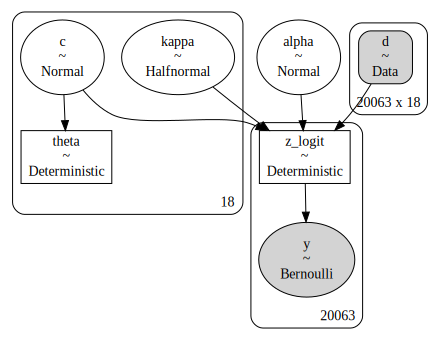

In [31]:
# Y: shape (J,), D: shape (J,K)
m = build_single_agent_optionC(
    Y, D,
    lam=1.0,            # ×e per level (use np.log(3) for ×3, etc.)
    mu_c=3.0, sigma_c=1.0,
    alpha_prior=(0.0, 0.5),
    kappa_sd=1.0,
    gamma0=None          # if you want near-certain success on all-zero rows, then set to 8
)
pm.model_to_graphviz(m)

# After sampling:
# idata.posterior["c"]  -> capability levels (same ruler as D)
# idata.posterior["theta"] -> ratio-scale capabilities
# idata.posterior["kappa"], ["alpha"], ["p"] -> interpretable parameters & predicted probs

In [46]:
with m:
    idata = pm.sample(tune=2000, draws=4000, target_accept=0.95, random_seed=42, nuts_sampler="numpyro")

/usr/local/lib/python3.12/dist-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 6000/6000 [01:41<00:00, 59.10it/s, 63 steps of size 9.21e-02. acc. prob=0.96]


In [47]:
az.summary(idata, var_names=["c", "theta", "kappa", "alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c[0],2.441,0.452,1.746,3.309,0.006,0.007,8255.0,6069.0,1.0
c[1],1.278,0.078,1.135,1.429,0.001,0.001,16253.0,11388.0,1.0
c[2],1.607,0.124,1.368,1.835,0.001,0.001,13604.0,11151.0,1.0
c[3],1.612,0.097,1.431,1.798,0.001,0.001,13419.0,11527.0,1.0
c[4],1.555,0.067,1.432,1.685,0.001,0.001,15442.0,11664.0,1.0
c[5],1.486,0.079,1.338,1.635,0.001,0.001,15403.0,11197.0,1.0
c[6],1.037,0.080,0.887,1.189,0.001,0.001,11785.0,11540.0,1.0
c[7],1.683,0.122,1.464,1.918,0.001,0.001,10146.0,9390.0,1.0
c[8],1.496,0.063,1.379,1.616,0.001,0.000,15497.0,11941.0,1.0
c[9],1.938,0.264,1.500,2.447,0.003,0.005,10934.0,7123.0,1.0


## Posteriors

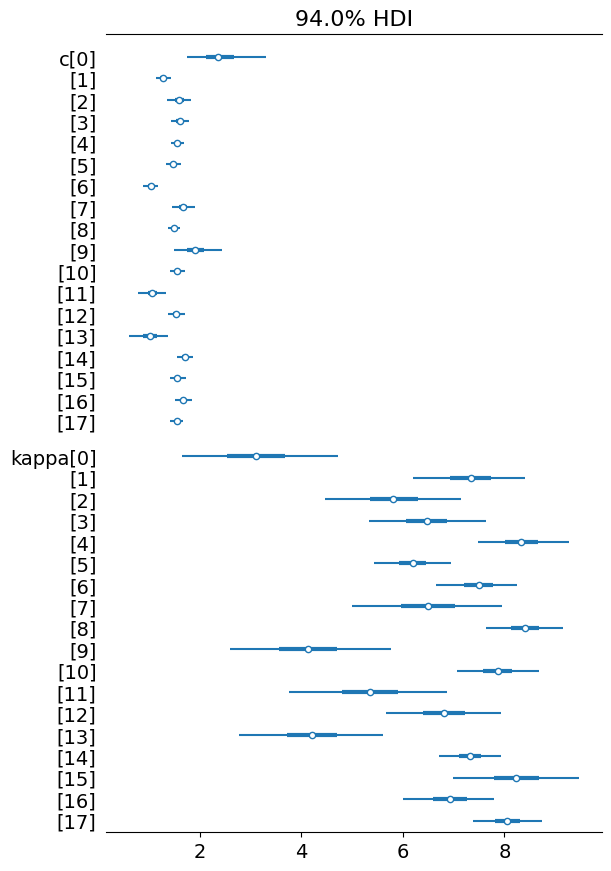

In [48]:
#az.plot_posterior(idata, var_names=["c","theta","kappa","alpha"], hdi_prob=0.95);
az.plot_forest(idata, var_names=["c","kappa"], combined=True);

## Posterior predictive check

Output()

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


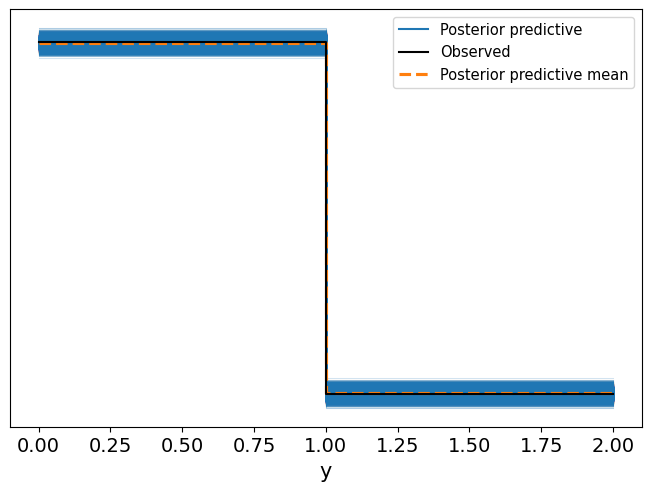

In [40]:
with m:
    ppc = pm.sample_posterior_predictive(idata, var_names=["y"])

az.plot_ppc(ppc, data_pairs={"y":"y"});

## Item Characteristic Curve (ICC) style plots

Pick a capability $k$, vary demand d from 0→5, and plot $p(d)$ using posterior means.

A one-dimensional $p(d)$ plot is not a full predictive curve — it's a conditional slice of the model:

> If only capability $k$ mattered and all other demands were 0, how would success vary with difficulty $d$?


You can also make the plot more realistic by holding the average contributions from other dimensions fixed.

That gives you a conditional marginal curve for capability k while accounting for “typical” difficulty elsewhere.

In [49]:
def plot_icc_for_capability(
    idata, capability_cols, D, k,
    lam=1.0,
    include_other=False
):
    """
    Plot an ICC-style curve for capability k.

    If include_other=True, adds the average contribution from other capabilities
    (based on posterior means and mean demand levels in D).
    """

    # posterior means
    c_mean   = idata.posterior["c"].mean(dim=("chain","draw")).to_numpy()
    kap_mean = idata.posterior["kappa"].mean(dim=("chain","draw")).to_numpy()
    alpha    = float(idata.posterior["alpha"].mean(dim=("chain","draw")))

    K = len(c_mean)
    lam = np.broadcast_to(lam, K)

    # capability k values
    c_k, kap_k, lam_k = c_mean[k], kap_mean[k], lam[k]

    # mean demand per dimension (used for avg_other)
    d_mean = np.mean(D, axis=0)

    # optional average contribution from other capabilities
    if include_other:
        avg_other = np.mean([
            kap_mean[i] * (c_mean[i] - lam[i] * d_mean[i])
            for i in range(K) if i != k
        ])
    else:
        avg_other = 0.0

    # compute curve
    d_grid = np.linspace(0, 5, 61)
    is_on = (d_grid > 0).astype(float)
    margin = is_on * (c_k - lam_k * d_grid)
    z = alpha + avg_other + kap_k * margin
    p = sigmoid(z)

    # plot
    plt.figure(figsize=(5, 3))
    plt.plot(d_grid, p, lw=2)
    plt.xlabel("Demand level d")
    plt.ylabel("P(success)")
    plt.title(f"ICC for {capability_cols[k]}" + (" (with avg other dims)" if include_other else ""))
    plt.grid(alpha=0.3)
    plt.show()

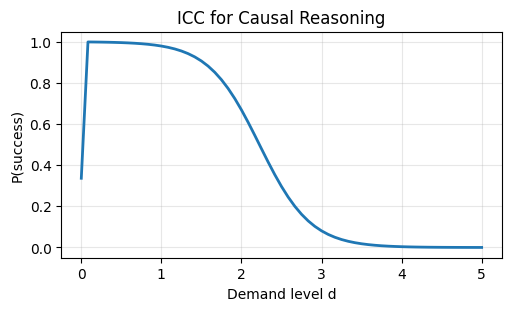

In [52]:
plot_icc_for_capability(idata, capability_cols, D, k=0)

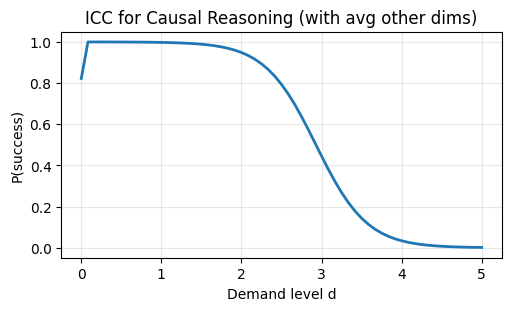

In [53]:
plot_icc_for_capability(idata, capability_cols, D, k=0, include_other=True)

In [54]:
c_mean = idata.posterior["c"].mean(dim=("chain", "draw")).to_numpy()

In [55]:
pd.Series(c_mean, index=capability_cols, name=f"{agent_name}_c_mean")

,weaker_c_mean
Causal Reasoning,2.441165
Cognitive Flexibility,1.277549
Emotion Perception and Empathy,1.607197
Episodic Memory,1.611628
Functional Perception,1.555250
Inhibitory Control,1.485783
Language,1.037070
Mental Simulation,1.682670
Metacognition,1.496000
Object Permanence,1.938185


In [89]:
def collect_capability_means(agent_idata_dict, capability_cols):
    """
    agent_idata_dict: dict[str -> InferenceData]  (one idata per agent)
    capability_cols : list-like of capability names (length K)
    returns: DataFrame (index=agents, columns=capabilities) with posterior mean of c
    """
    rows = {}
    for agent, idata in agent_idata_dict.items():
        c_mean = idata.posterior["c"].mean(dim=("chain","draw")).to_numpy()
        rows[agent] = pd.Series(c_mean, index=capability_cols)
    return pd.DataFrame.from_dict(rows, orient="index")

In [106]:
def plot_radar_capabilities(
    cap_df,
    overlay=True,
    agents=None,
    rlim=(0, 5),
    fill_alpha=0.15,
    figsize=(8, 8),
    title="Learned capability levels (posterior means)",
    save_path=None,           # e.g. "figures/radar_plot.pdf"
    dpi=300,                  # for high-quality PNGs
):
    """
    Plot radar (spider) charts of capability means per agent.
    Saves high-quality output if save_path is provided.
    """

    # --- capability order and short-name mapping ---
    capability_order = [
        "Episodic Memory", "Semantic Memory", "Procedural Memory",
        "Prospective Memory", "Working Memory",
        "Inhibitory Control", "Cognitive Flexibility",
        "Perception and Pattern Recognition", "Functional Perception",
        "Spatial Reasoning and Navigation", "Object Permanence",
        "Theory of Mind", "Emotion Perception and Empathy",
        "Language", "Mental Simulation", "Metacognition",
        "Causal Reasoning", "Planning"
    ]

    short_labels = {
        "Causal Reasoning": "CR",
        "Cognitive Flexibility": "CF",
        "Emotion Perception and Empathy": "EPE",
        "Episodic Memory": "EM",
        "Functional Perception": "FP",
        "Inhibitory Control": "IC",
        "Language": "LG",
        "Mental Simulation": "MS",
        "Metacognition": "MC",
        "Object Permanence": "OP",
        "Perception and Pattern Recognition": "PPR",
        "Planning": "PL",
        "Procedural Memory": "PM",
        "Prospective Memory": "PrM",
        "Semantic Memory": "SM",
        "Spatial Reasoning and Navigation": "SRN",
        "Theory of Mind": "ToM",
        "Working Memory": "WM",
    }

    # --- ensure order & short labels ---
    labels = [short_labels[c] for c in capability_order if c in cap_df.columns]
    cap_df = cap_df[capability_order]

    if agents is None:
        agents = list(cap_df.index)

    K = len(labels)
    angles = np.linspace(0, 2*np.pi, K, endpoint=False)
    angles = np.concatenate([angles, angles[:1]])  # close polygon

    def close(vals):
        vals = np.asarray(vals, float)
        return np.concatenate([vals, vals[:1]])

    # --- plot setup ---
    if overlay:
        fig = plt.figure(figsize=figsize)
        ax = plt.subplot(111, polar=True)
        for agent in agents:
            vals = cap_df.loc[agent, :].values
            ax.plot(angles, close(vals), linewidth=2, label=str(agent))
            ax.fill(angles, close(vals), alpha=fill_alpha)
        ax.set_ylim(*rlim)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels, fontsize=14)
        yticks = np.arange(np.floor(rlim[0]), np.ceil(rlim[1]) + 1, 1)
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{int(t)}" for t in yticks], fontsize=11)
        ax.set_title(title, pad=40, fontsize=16, weight="bold")

        # --- bigger legend ---
        legend = ax.legend(
            loc="upper right",
            bbox_to_anchor=(1.3, 1.15),
            fontsize=14,
            frameon=False
        )

        plt.tight_layout()

        # --- save high-quality version ---
        if save_path is not None:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            ext = os.path.splitext(save_path)[1].lower()
            if ext in [".pdf", ".svg"]:
                plt.savefig(save_path, bbox_inches="tight")  # vector quality
            else:
                plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
            print(f"✅ Saved radar plot to {save_path}")

        plt.show()

    else:
        # --- separate subplot per agent ---
        n = len(agents)
        ncols = 3 if n >= 3 else n
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, subplot_kw=dict(polar=True), figsize=(ncols*5, nrows*5))
        axes = np.atleast_1d(axes).ravel()
        for ax, agent in zip(axes, agents):
            vals = cap_df.loc[agent, :].values
            ax.plot(angles, close(vals), linewidth=2, label=str(agent))
            ax.fill(angles, close(vals), alpha=fill_alpha)
            ax.set_ylim(*rlim)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(labels, fontsize=14)
            yticks = np.arange(np.floor(rlim[0]), np.ceil(rlim[1]) + 1, 1)
            ax.set_yticks(yticks)
            ax.set_yticklabels([f"{int(t)}" for t in yticks], fontsize=11)
            ax.set_title(str(agent), pad=20, fontsize=14, weight="bold")
        for ax in axes[len(agents):]:
            ax.set_visible(False)
        plt.suptitle(title, y=0.98, fontsize=16, weight="bold")
        plt.tight_layout()

        if save_path is not None:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            ext = os.path.splitext(save_path)[1].lower()
            if ext in [".pdf", ".svg"]:
                plt.savefig(save_path, bbox_inches="tight")
            else:
                plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
            print(f"✅ Saved radar plot to {save_path}")

        plt.show()

In [107]:
# --- 3) Collect capability means (posterior mean of c for each agent) ---
def collect_capability_means(agent_idata_dict, capability_cols):
    rows = {}
    for agent, idata in agent_idata_dict.items():
        c_mean = idata.posterior["c"].mean(dim=("chain","draw")).to_numpy()
        rows[agent] = pd.Series(c_mean, index=capability_cols)
    return pd.DataFrame.from_dict(rows, orient="index")

capability_df = collect_capability_means(agent_idata, capability_cols)

In [108]:
#agent_idata = {
    #"generalist": idata_generalist,
    #"specialist": idata_specialist,
#    "weaker": idata,
#}
#capability_df = collect_capability_means(agent_idata, capability_cols)

/tmp/ipython-input-2244589289.py:89: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


✅ Saved radar plot to /content/drive/MyDrive/Colab Notebooks/OECD capability profiles/capabilities_radar_overlay.png


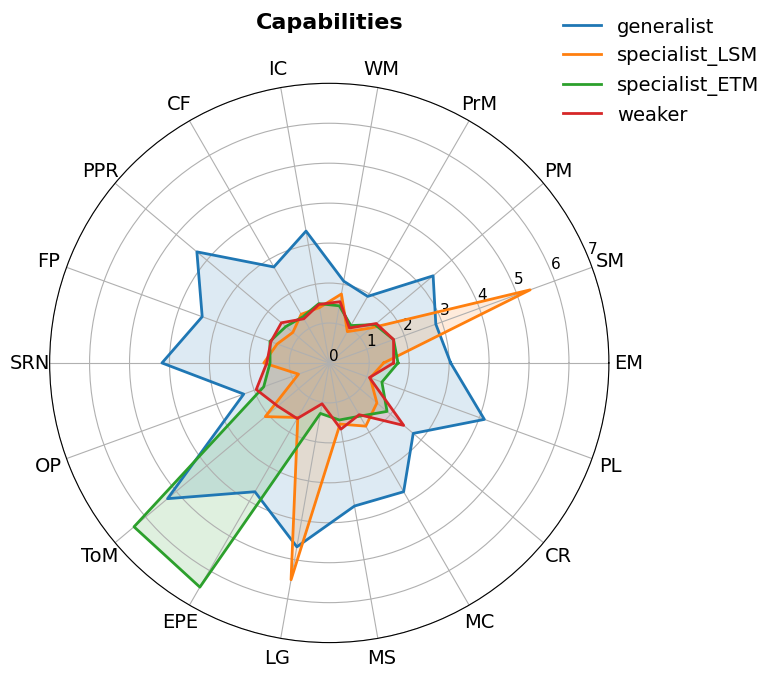

In [111]:
plot_radar_capabilities(
    capability_df,
    overlay=True,
    title="Capabilities",
    rlim=(0, 7),
    save_path="/content/drive/MyDrive/Colab Notebooks/OECD capability profiles/capabilities_radar_overlay.png"  # or .png, .svg
)

# Simulate suitability scores

In [128]:
tasks = [
    "admin",
    "analysing data",
    "building rapport",
    "communicating",
    "computer work",
    "creativity",
    "decision making",
    "getting information",
    "judging quality",
    "managing",
    "manual work",
    "planning",
]

# ---- Capabilities (columns from heatmap + add 'theory of mind') ----
capabilities = [
    "affordances",
    "attribution",
    "causal reasoning",
    "cognitive flexibility",
    "communication",
    "episodic memory",
    "inhibitory control",
    "mental simulation",
    "metacognition",
    "object permanence",
    "perception",
    "planning",
    "procedural memory",
    "prospective memory",
    "semantic memory",
    "spatial navigation",
    "working memory",
    "theory of mind",  # simulated
]

# ---- Approximate numeric values from the heatmap ----
data = [
    # aff, att, cau, cog, com, epi, inh, men, met, obj, per, pla, pro, prm, sem, spn, wkm
    [1.8, 0.4, 1.1, 1.2, 2.5, 0.9, 0.8, 1.2, 0.7, 0.9, 1.8, 2.0, 0.9, 2.7, 0.1, 3.1, 0.0],  # admin
    [2.5, 0.9, 2.5, 2.0, 1.1, 1.0, 0.8, 1.3, 1.2, 0.9, 3.0, 2.5, 1.0, 4.3, 0.7, 4.6, 0.0],  # analysing data
    [1.0, 4.2, 0.8, 1.0, 8.0, 1.2, 0.6, 2.3, 1.1, 1.1, 3.8, 1.1, 0.7, 3.3, 1.0, 1.0, 0.0],  # building rapport
    [1.1, 4.2, 3.0, 2.5, 22.4, 3.1, 1.0, 3.1, 1.0, 1.5, 3.4, 3.6, 2.2, 6.4, 1.5, 5.5, 0.0], # communicating
    [3.7, 1.2, 1.7, 5.2, 5.2, 1.8, 1.2, 1.4, 1.7, 2.1, 5.1, 10.2, 3.2, 5.4, 0.3, 6.2, 0.0], # computer work
    [2.1, 1.2, 0.5, 0.7, 1.0, 0.8, 0.2, 1.5, 0.6, 0.8, 3.5, 1.6, 0.9, 0.8, 0.1, 1.5, 0.0],  # creativity
    [6.1, 3.5, 5.8, 3.7, 6.3, 1.8, 2.8, 4.5, 2.2, 1.6, 11.4, 3.3, 1.3, 5.3, 1.2, 5.7, 0.0], # decision making
    [2.5, 1.8, 1.5, 2.3, 6.3, 1.4, 0.9, 2.5, 0.4, 0.7, 3.1, 4.7, 2.8, 1.2, 5.9, 6.1, 0.0],  # getting information
    [2.8, 0.9, 2.0, 2.2, 2.1, 2.0, 0.8, 2.8, 1.4, 0.3, 5.6, 3.9, 2.7, 1.4, 2.7, 0.4, 0.0],  # judging quality
    [0.8, 2.0, 1.1, 4.1, 6.8, 1.0, 0.5, 0.7, 1.1, 1.5, 2.0, 2.2, 0.2, 2.6, 0.5, 2.9, 0.0],  # managing
    [3.6, 1.0, 1.5, 2.4, 0.6, 0.9, 0.2, 1.6, 0.7, 0.9, 2.1, 2.6, 7.5, 1.7, 1.8, 4.4, 0.0],  # manual work
    [3.3, 1.4, 1.7, 5.1, 3.8, 2.1, 2.2, 1.9, 1.7, 1.3, 10.8, 3.6, 4.3, 4.9, 1.3, 5.2, 0.0], # planning
]

demand_df = pd.DataFrame(data, index=tasks, columns=capabilities[:-1])

# ---- Add 'theory of mind' column (not shown in figure) ----
# Simulate plausible values: higher for social/communication tasks
rng = np.random.default_rng(42)
theory_of_mind = rng.normal(loc=2.0, scale=0.6, size=len(tasks))
for t in ["building rapport", "communicating", "managing", "decision making"]:
    theory_of_mind[tasks.index(t)] += rng.uniform(1.0, 2.0)
demand_df["theory of mind"] = np.clip(theory_of_mind, 0.3, 5.0).round(1)

# Final cleanup and rounding
demand_df = demand_df.round(1)

# Preview
print(demand_df.head(3))

                  affordances  attribution  causal reasoning  \
admin                     1.8          0.4               1.1   
analysing data            2.5          0.9               2.5   
building rapport          1.0          4.2               0.8   

                  cognitive flexibility  communication  episodic memory  \
admin                               1.2            2.5              0.9   
analysing data                      2.0            1.1              1.0   
building rapport                    1.0            8.0              1.2   

                  inhibitory control  mental simulation  metacognition  \
admin                            0.8                1.2            0.7   
analysing data                   0.8                1.3            1.2   
building rapport                 0.6                2.3            1.1   

                  object permanence  perception  planning  procedural memory  \
admin                           0.9         1.8       2.0        

In [129]:
name_map = {
    "causal reasoning": "Causal Reasoning",
    "cognitive flexibility": "Cognitive Flexibility",
    "communication": "Language",  # if you map their "communication" to your "Language"
    "episodic memory": "Episodic Memory",
    "inhibitory control": "Inhibitory Control",
    "mental simulation": "Mental Simulation",
    "metacognition": "Metacognition",
    "object permanence": "Object Permanence",
    "perception": "Perception and Pattern Recognition",
    "planning": "Planning",
    "procedural memory": "Procedural Memory",
    "prospective memory": "Prospective Memory",
    "semantic memory": "Semantic Memory",
    "spatial navigation": "Spatial Reasoning and Navigation",
    "working memory": "Working Memory",
    "theory of mind": "Theory of Mind",
    "affordances": "Functional Perception",      # or your preferred mapping
    "attribution": "Emotion Perception and Empathy",  # or your preferred mapping
}

demand_df_named = demand_df.rename(columns=name_map)
# If you want your exact column order from earlier:
canonical_order = [
    "Episodic Memory", "Semantic Memory", "Procedural Memory", "Prospective Memory", "Working Memory",
    "Inhibitory Control", "Cognitive Flexibility",
    "Perception and Pattern Recognition", "Functional Perception", "Spatial Reasoning and Navigation", "Object Permanence",
    "Theory of Mind", "Emotion Perception and Empathy",
    "Language", "Mental Simulation", "Metacognition",
    "Causal Reasoning", "Planning",
]
# keep only columns that exist, in order:
present = [c for c in canonical_order if c in demand_df_named.columns]
demand_df_named = demand_df_named.reindex(columns=present)

In [130]:
demand_df_named

,Episodic Memory,Semantic Memory,Procedural Memory,Prospective Memory,Working Memory,Inhibitory Control,Cognitive Flexibility,Perception and Pattern Recognition,Functional Perception,Spatial Reasoning and Navigation,Object Permanence,Theory of Mind,Emotion Perception and Empathy,Language,Mental Simulation,Metacognition,Causal Reasoning,Planning
admin,0.9,0.1,0.9,2.7,0.0,0.8,1.2,1.8,1.8,3.1,0.9,2.2,0.4,2.5,1.2,0.7,1.1,2.0
analysing data,1.0,0.7,1.0,4.3,0.0,0.8,2.0,3.0,2.5,4.6,0.9,1.4,0.9,1.1,1.3,1.2,2.5,2.5
building rapport,1.2,1.0,0.7,3.3,0.0,0.6,1.0,3.8,1.0,1.0,1.1,4.1,4.2,8.0,2.3,1.1,0.8,1.1
communicating,3.1,1.5,2.2,6.4,0.0,1.0,2.5,3.4,1.1,5.5,1.5,4.4,4.2,22.4,3.1,1.0,3.0,3.6
computer work,1.8,0.3,3.2,5.4,0.0,1.2,5.2,5.1,3.7,6.2,2.1,0.8,1.2,5.2,1.4,1.7,1.7,10.2
creativity,0.8,0.1,0.9,0.8,0.0,0.2,0.7,3.5,2.1,1.5,0.8,1.2,1.2,1.0,1.5,0.6,0.5,1.6
decision making,1.8,1.2,1.3,5.3,0.0,2.8,3.7,11.4,6.1,5.7,1.6,3.3,3.5,6.3,4.5,2.2,5.8,3.3
getting information,1.4,5.9,2.8,1.2,0.0,0.9,2.3,3.1,2.5,6.1,0.7,1.8,1.8,6.3,2.5,0.4,1.5,4.7
judging quality,2.0,2.7,2.7,1.4,0.0,0.8,2.2,5.6,2.8,0.4,0.3,2.0,0.9,2.1,2.8,1.4,2.0,3.9
managing,1.0,0.5,0.2,2.6,0.0,0.5,4.1,2.0,0.8,2.9,1.5,2.9,2.0,6.8,0.7,1.1,1.1,2.2


In [151]:
def extract_cap_samples(idata, var="c", draws=2000, chains=None, capability_cols=None):
    """Return (draws, K) samples of capabilities for one agent."""
    x = idata.posterior[var]  # dims: chain, draw, variable_dim

    # Find the dimension name that is NOT 'chain' or 'draw'
    var_dim_name = [d for d in x.dims if d not in ["chain", "draw"]][0]

    if chains is not None:
        x = x.sel(chain=chains)
    # stack chains and draws, then subsample
    x = x.stack(sample=("chain","draw")).transpose("sample",var_dim_name).values  # (S, K)
    if draws is not None and draws < x.shape[0]:
        idx = np.random.default_rng(0).choice(x.shape[0], size=draws, replace=False)
        x = x[idx]
    return x  # (draws, K)

## Use either demand_weights or smooth_demand_weights
def demand_weights(row, normalize=True, zero_as_zero=True):
    """From a demand row (shape K), produce weights w (shape K)."""
    w = np.asarray(row, float).copy()
    if zero_as_zero:
        w[w < 1e-12] = 0.0
    if normalize:
        s = w.sum()
        if s > 0:
            w = w / s
    return w

def smooth_demand_weights(row, eps=1e-3):
    w = np.asarray(row, float)
    w = w + eps
    w = w / w.sum()
    return w

def sample_weights_from_profile(row, kappa=200.0, rng=None):
    """
    Turn an empirical demand profile into a Dirichlet around its normalized proportions.
    kappa is the concentration (larger => less uncertainty).
    """
    rng = np.random.default_rng(rng)
    base = smooth_demand_weights(row)  # proportions p normalize=True, zero_as_zero=True
    alpha = np.maximum(base * kappa, 1e-6)  # avoid zeros
    return rng.dirichlet(alpha)  # (K,)

def simulate_scores_for_task(
    agent_idata: dict,
    capability_cols: list,
    demand_df: pd.DataFrame,
    task: str,
    draws_cap=2000,
    use_ratio=False,          # False => use level c; True => use ratio theta = exp(c)
    weight_uncertainty=None,  # None => fixed normalized weights; "dirichlet" => sample around profile
    kappa=200.0,              # Dirichlet concentration if weight_uncertainty="dirichlet"
    rng=None
):
    """
    Returns a DataFrame with per-agent score samples S and summary stats (mean, CI).
    S^(k) = sum_i w_i * capability_i  (weights normalized to sum=1).
    """
    rng = np.random.default_rng(rng)
    # demand row for the task (ensure column order)
    w_row = demand_df.loc[task, capability_cols].to_numpy(float)
    fixed_w = demand_weights(w_row, normalize=True, zero_as_zero=True)

    results = {}
    for agent, idata in agent_idata.items():
        cap_samples = extract_cap_samples(idata, var="c", draws=draws_cap)
        if use_ratio:
            cap_samples = np.exp(cap_samples)  # theta = exp(c)

        # weights: either fixed, or sample one per draw
        if weight_uncertainty == "dirichlet":
            W = np.vstack([sample_weights_from_profile(w_row, kappa=kappa, rng=rng)
                           for _ in range(cap_samples.shape[0])])  # (draws, K)
        else:
            W = np.broadcast_to(fixed_w, cap_samples.shape)        # (draws, K)

        S = (W * cap_samples).sum(axis=1)  # (draws,)
        results[agent] = S

    # assemble summary
    S_df = pd.DataFrame({k: v for k, v in results.items()})  # columns=agents
    summary = pd.DataFrame({
        "mean": S_df.mean(axis=0),
        "sd":   S_df.std(axis=0),
        "hdi_2.5%": S_df.quantile(0.025, axis=0),
        "hdi_97.5%": S_df.quantile(0.975, axis=0)
    }).sort_values("mean", ascending=False)

    return S_df, summary

In [152]:
task = "communicating"  # pick a row from your demand heatmap
S_samples, S_summary = simulate_scores_for_task(
    agent_idata,
    capability_cols=capability_cols,
    demand_df=demand_df_named,
    task=task,
    draws_cap=2000,
    use_ratio=False,              # use c-level (same ruler as demands)
    weight_uncertainty="dirichlet",  # or None for fixed weights
    kappa=300.0,                  # higher = tighter around the observed profile
    rng=123
)
print(S_summary)

                    mean        sd  hdi_2.5%  hdi_97.5%
generalist      3.868136  0.211106  3.479431   4.294045
specialist_LSM  2.805870  0.152076  2.535738   3.117499
specialist_ETM  2.017481  0.113759  1.807958   2.244154
weaker          1.373965  0.042584  1.293034   1.459835


In [153]:
def score_all_tasks(
    agent_idata,
    capability_cols,
    demand_df_named,
    tasks=None,
    draws_cap=2000,
    use_ratio=False,              # keep False for log/level aggregation
    weight_uncertainty="dirichlet",
    kappa=300.0,
    rng=123
):
    """
    Returns:
      mean_df : (tasks x agents) DataFrame of mean scores
      ci_lo_df, ci_hi_df : same shape, 2.5% and 97.5% quantiles
      samples_dict : dict task -> DataFrame of samples (draws x agents)
    """
    if tasks is None:
        tasks = list(demand_df_named.index)

    # --- sanity checks to prevent misalignment ---
    missing_cols = [c for c in capability_cols if c not in demand_df_named.columns]
    if missing_cols:
        raise ValueError(f"demand_df_named is missing columns: {missing_cols}")
    missing_tasks = [t for t in tasks if t not in demand_df_named.index]
    if missing_tasks:
        raise ValueError(f"demand_df_named is missing task rows: {missing_tasks}")

    mean_rows = []
    lo_rows = []     # <-- fix
    hi_rows = []     # <-- fix
    samples_dict = {}

    for task in tasks:
        S_samples, S_summary = simulate_scores_for_task(
            agent_idata=agent_idata,
            capability_cols=capability_cols,
            demand_df=demand_df_named,
            task=task,
            draws_cap=draws_cap,
            use_ratio=use_ratio,
            weight_uncertainty=weight_uncertainty,
            kappa=kappa,
            rng=rng
        )
        # store samples per task (draws x agents)
        samples_dict[task] = S_samples

        # collect summaries as rows
        mean_rows.append(pd.Series(S_summary["mean"],      name=task))
        lo_rows.append(  pd.Series(S_summary["hdi_2.5%"],  name=task))
        hi_rows.append(  pd.Series(S_summary["hdi_97.5%"], name=task))

    mean_df = pd.DataFrame(mean_rows).reindex(tasks)
    ci_lo_df = pd.DataFrame(lo_rows).reindex(tasks)
    ci_hi_df = pd.DataFrame(hi_rows).reindex(tasks)
    return mean_df, ci_lo_df, ci_hi_df, samples_dict

In [154]:
mean_df, ci_lo_df, ci_hi_df, samples_by_task = score_all_tasks(
    agent_idata=agent_idata,
    capability_cols=capability_cols,      # must match model’s order
    demand_df_named=demand_df_named,
    tasks=list(demand_df_named.index),
    draws_cap=2000,
    use_ratio=False,
    weight_uncertainty="dirichlet",
    kappa=300.0,
    rng=123
)

mean_df

,generalist,specialist_ETM,specialist_LSM,weaker
admin,3.669984,1.968154,1.839038,1.462725
analysing data,3.468060,1.818134,1.603078,1.504930
building rapport,3.866465,2.553396,2.443617,1.434307
communicating,3.868136,2.017481,2.805870,1.373965
computer work,3.591986,1.606027,1.715760,1.390296
creativity,3.757843,2.098998,1.624046,1.518260
decision making,3.649106,1.952264,1.834962,1.531450
getting information,3.725288,1.872660,2.484204,1.476590
judging quality,3.644572,1.888883,1.920506,1.517865
managing,3.750487,2.156756,2.321598,1.405830


/tmp/ipython-input-1614840914.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


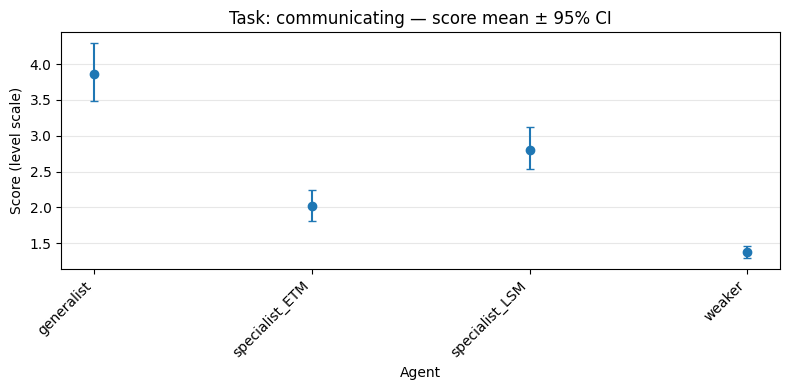

In [137]:
def plot_task_errorbars(mean_df, ci_lo_df, ci_hi_df, task, figsize=(8,4)):
    agents = list(mean_df.columns)
    means = mean_df.loc[task, agents].values
    los   = ci_lo_df.loc[task, agents].values
    his   = ci_hi_df.loc[task, agents].values
    err_lo = means - los
    err_hi = his - means

    x = np.arange(len(agents))
    plt.figure(figsize=figsize)
    plt.errorbar(x, means, yerr=[err_lo, err_hi], fmt="o", capsize=3)
    plt.xticks(x, agents, rotation=45, ha="right")
    plt.xlabel("Agent")
    plt.ylabel("Score (level scale)")
    plt.title(f"Task: {task} — score mean ± 95% CI")
    plt.grid(alpha=0.3, axis="y")
    plt.tight_layout()
    plt.show()

# Example:
plot_task_errorbars(mean_df, ci_lo_df, ci_hi_df, task="communicating")

In [155]:
def plot_all_tasks_errorbars(
    mean_df,
    ci_lo_df,
    ci_hi_df,
    figsize=(14,6),
    title="Task scores by agent",
    sort_tasks=False,
    jitter=0.1,                 # horizontal jitter for readability
    seed=42,
    save_path=None,             # e.g. "figures/task_scores.pdf"
    dpi=300
):
    """
    Plot all tasks (x-axis) with mean ± 95% CI scores per agent.
    Keeps line connections, legend outside, and can save high-quality figure.
    """

    rng = np.random.default_rng(seed)
    tasks = list(mean_df.index)
    agents = list(mean_df.columns)

    # --- Optionally sort tasks by average score across agents ---
    if sort_tasks:
        task_order = mean_df.mean(axis=1).sort_values(ascending=False).index
        mean_df = mean_df.loc[task_order]
        ci_lo_df = ci_lo_df.loc[task_order]
        ci_hi_df = ci_hi_df.loc[task_order]
        tasks = list(task_order)

    x = np.arange(len(tasks))
    plt.figure(figsize=figsize)

    # --- Matplotlib default colour cycle (same as before) ---
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    for i, agent in enumerate(agents):
        means = mean_df[agent].values
        los   = ci_lo_df[agent].values
        his   = ci_hi_df[agent].values
        err_lo = means - los
        err_hi = his - means

        # small horizontal jitter for visibility
        x_jittered = x + rng.uniform(-jitter, jitter, size=len(x))

        plt.errorbar(
            x_jittered, means, yerr=[err_lo, err_hi],
            fmt="o-", capsize=3, label=agent,
            color=colors[i % len(colors)], alpha=0.9,
            markersize=5, lw=2
        )

    # --- Styling ---
    plt.xticks(x, tasks, rotation=45, ha="right", fontsize=11)
    plt.ylabel("Score (level scale)", fontsize=12)
    plt.title(title, fontsize=15, weight="bold", pad=20)
    plt.grid(alpha=0.3, axis="y")

    # --- Legend outside the plot ---
    plt.legend(
        title="Agent",
        fontsize=12,
        title_fontsize=12,
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0,
        frameon=False
    )

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave room for legend

    # --- Optional save ---
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        ext = os.path.splitext(save_path)[1].lower()
        if ext in [".pdf", ".svg"]:
            plt.savefig(save_path, bbox_inches="tight")
        else:
            plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
        print(f"✅ Saved plot to {save_path}")

    plt.show()

/tmp/ipython-input-2413425815.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave room for legend


✅ Saved plot to /content/drive/MyDrive/Colab Notebooks/OECD capability profiles/suitability_task_scores.png


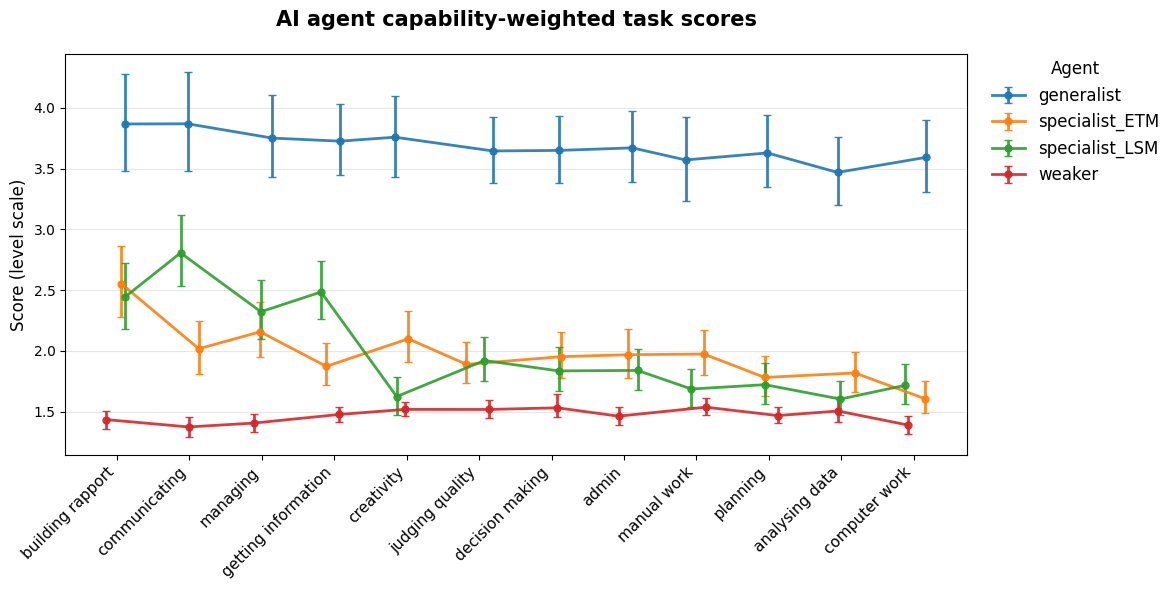

In [157]:
plot_all_tasks_errorbars(
    mean_df,
    ci_lo_df,
    ci_hi_df,
    figsize=(14,6),
    title="AI agent capability-weighted task scores",
    sort_tasks=True,
    jitter=0.2,
    save_path="/content/drive/MyDrive/Colab Notebooks/OECD capability profiles/suitability_task_scores.png"  # or "figures/task_scores.png"
)

Your scale is multiplicative at the ratio level; averaging logs gives a geometric mean on the ratio scale

- You assume the task’s “effective difficulty match” is a weighted sum of single-capability contributions (no interactions).
-